In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize 

import pickle
from sklearn import metrics
import nltk
import os
from nltk.corpus import stopwords
from textblob import Word
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mandi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv("input500.csv")
df

,Subject,Body
0,SUTDReviews --- Sharing reviews on SUTD Mods,SUTDFam!!\n\n \n\nHaving trouble deciding wha...
1,Request for Interview for Pedagogical Project,",\n\nThanks for responding. The online form i..."
2,Change of Name for the ISTD Degree Programme,"Students,\n\n \n\nSUTD will be changing the n..."
3,Fw: 88 Call for Stories,\n\n________________________________\n\n Parul...
4,Revised Student Exco and Cohort Advisor prog...,"Student Reps,\n\n \n\nThank you for your mitm..."
...,...,...
495,Request for Quotation,External Email – Do not click on any links or ...
496,Request for Quotation,"Carrie,\n\n \n\nThank you for the prompt repl..."
497,Request for Quotation,"Jerrard,\n\n \n\nThank you for the prompt rep..."
498,Infographics for Sept 2021 Subject Enrolment E...,"SUTD Family,\n\nAs the Cabinet of the 9th SUT..."


In [3]:
df['Body'] = df['Body'].astype(str)
df['Body'] = df['Body'].apply(lambda x: x.lower())
punctuations = '\.\!\?'
df = (df.drop('Body',axis=1).merge(df.Body.str.extractall(f'(?P<Body>[^{punctuations}]+[{punctuations}])\s?').reset_index('match'),left_index=True, right_index=True, how='left'))
df['Body'] = df['Body'].str.replace("[^\w\s<>]", "")
df = df.replace(r'[^0-9a-zA-Z ]', '', regex=True).replace("'", '')
#print(type(df['Body']))
#df.applymap(type)
df['Body'] = df['Body'].astype(str)
df['Body'] = df['Body'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) # change similar terms to the same
stop = stopwords.words("english") #remove useless words
df['Body'] = df['Body'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

df

,Subject,match,Body
0,SUTDReviews Sharing reviews on SUTD Mods,0.0,sutdfam
0,SUTDReviews Sharing reviews on SUTD Mods,1.0,trouble deciding mod take
0,SUTDReviews Sharing reviews on SUTD Mods,2.0,want find taken
0,SUTDReviews Sharing reviews on SUTD Mods,3.0,fret
0,SUTDReviews Sharing reviews on SUTD Mods,4.0,sutd senior came together create sutdreviews a...
...,...,...,...
499,Request for Quotation,174.0,message may contain confidential andor proprie...
499,Request for Quotation,175.0,intended recipient hereby notified use dissemi...
499,Request for Quotation,176.0,received email error please inform sender imme...
499,Request for Quotation,177.0,please delete message thereafter


In [4]:
#vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)

# max_df removes words that appears more than _%
# min_df removes words that appears less than _

vect = TfidfVectorizer(ngram_range=(1,3),
                     min_df = 10,
                     max_df = 0.4,
                     token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*[a-z]+\\w*\\b')
X = vect.fit_transform(df['Body'].values.astype('U'))

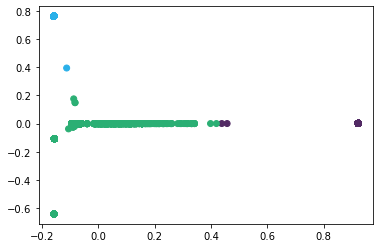

In [5]:
# Kmeans
from sklearn.cluster import KMeans
n_clusters = 6
clf = KMeans(n_clusters=n_clusters, max_iter=300, init='k-means++', n_init=1)
labels = clf.fit_predict(X)

# For larger datasets use mini-batch KMeans, so we dont have to read all data into memory.
# batch_size = 500
# clf = MiniBatchKMeans(n_clusters=n_clusters, init_size=1000, batch_size=batch_size, max_iter=100)  
# labels = clf.fit(X)

# Let's plot this with matplotlib to visualize it.
# First we need to make 2D coordinates from the sparse matrix.
X_dense = X.todense()
pca = PCA(n_components=2).fit(X_dense)
coords = pca.transform(X_dense)

# Lets plot it again, but this time we add some color to it.
# This array needs to be at least the length of the n_clusters.
label_colors = ["#2AB0E9", "#2BAF74", "#D7665E", "#CCCCCC", 
                "#D2CA0D", "#522A64", "#A3DB05", "#FC6514"]
colors = [label_colors[i] for i in labels]
# Plot clusters
plt.scatter(coords[:, 0], coords[:, 1], c=colors)





In [6]:
# top keywords in the emails

def top_tfidf_feats(row, features, top_n=20000):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

features = vect.get_feature_names()
print(top_feats_in_doc(X, features, 1, 10))

                  features  score
0                     take    1.0
1         zoom meetingsutd    0.0
2         ghlighted yellow    0.0
3               gexp minor    0.0
4                     gher    0.0
5                   ghland    0.0
6            ghland centre    0.0
7  ghland centre singapore    0.0
8                ghlighted    0.0
9                     gift    0.0


In [7]:
# top terms out of all the emails
def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=20000):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

print(top_mean_feats(X, features, top_n=10))

       features     score
0          sutd  0.078421
1    protection  0.042927
2     safelinks  0.042794
3       outlook  0.042604
4         apc01  0.025753
5         thank  0.020489
6  url3a2f2fwww  0.013405
7       student  0.011483
8           www  0.009382
9        please  0.008425


In [18]:
# extracts the top terms per cluster
features = vect.get_feature_names()
def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=10):
    dfs = []
    print(y)
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids,    min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

top_feats_per_cluster(X, labels, features, min_tfidf=0.1, top_n=10)

[1 1 1 ... 1 1 1]


ValueError: Can only tuple-index with a MultiIndex

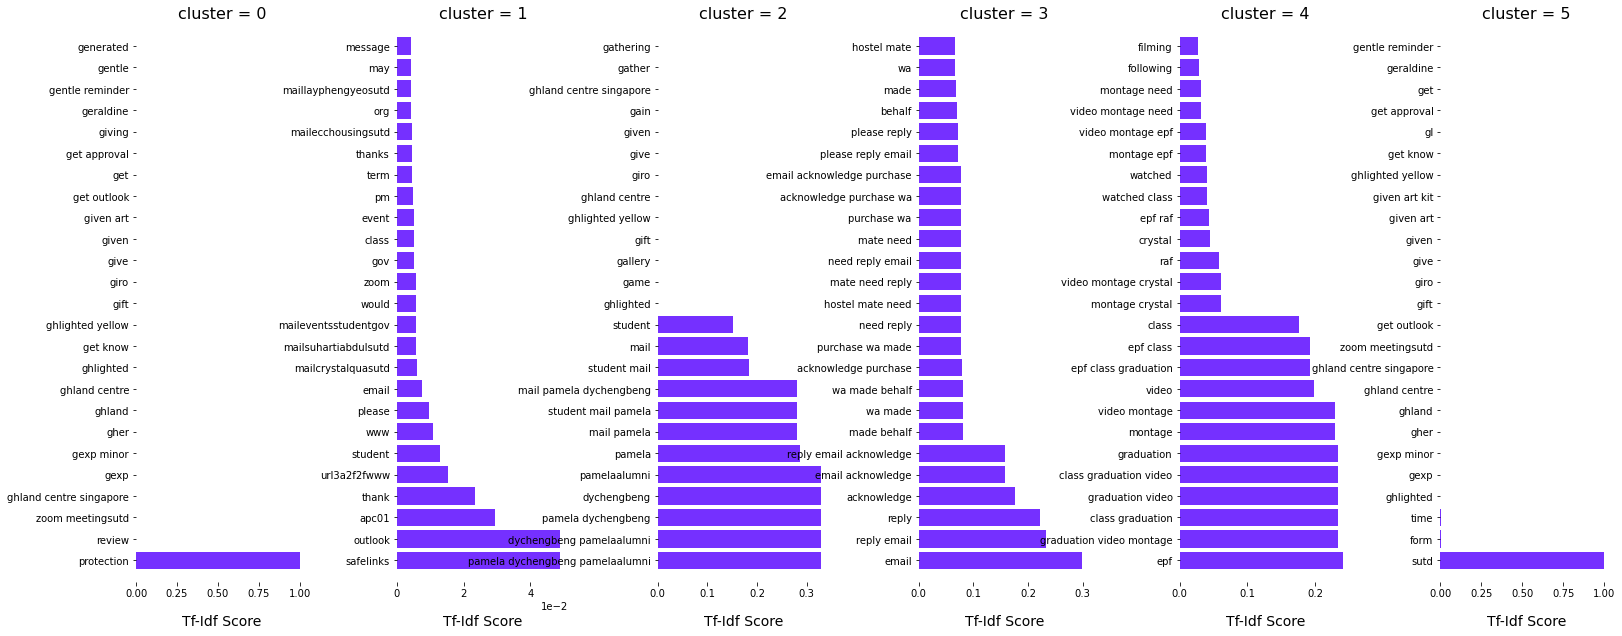

In [9]:
#Use this to print the top terms per cluster with matplotlib.

def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(25, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()


plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 25))

In [10]:
# km = KMeans(n_clusters=5).fit(df)

# cluster_map = pd.DataFrame()
# cluster_map['data_index'] = df.index.values
# cluster_map['cluster'] = clf.labels_

# cluster_map[cluster_map.cluster == 2]
#df.loc[df.ID == 103, 'FirstName'] = "Matt"
#df.loc[df[clf.labels_==0], 'Meetings'] = df.Categories 
#df.loc = df[clf.labels_==0]['Categories'].fillna('Meeting')
#df['Categories'][mask] = "Meeting"
#df.loc[df[clf.labels_==0], 'Categories'] = 'Meeting'

df['Classifications'] = pd.Series(labels, index=df.index)
# df_new = df[df['Classifications'] != 1]
# df_new

X = df['Body']
y = pd.to_numeric(df['Classifications'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101)

In [11]:
# count every word/phrase and put it into a matrix
vect = TfidfVectorizer(ngram_range=(1,3),
                     min_df = 5,
                     max_df = 0.4,
                     token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*[a-z]+\\w*\\b')
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

In [12]:
# converting sparse matrices into dense matrices
# replace empty spaces in the matrices with 0 (some sentences might not have a specific word)
X_train_dense = pd.DataFrame(X_train_dtm.toarray(), columns = vect.get_feature_names())
X_test_dense = pd.DataFrame(X_test_dtm.toarray(), columns = vect.get_feature_names())

In [13]:
pca = PCA(n_components = 20) # put a reasonable number from graph (70%-90%)
X_train_pca = pca.fit_transform(X_train_dense)
X_test_pca = pca.transform(X_test_dense)

In [14]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=20, criterion="entropy", n_jobs=-1, random_state=0)
rfc.fit(X_train_pca, y_train)
predictions = rfc.predict(X_test_pca)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[ 250    0    0    0    0    0]
 [   0 5176    0    0    0    0]
 [   0    0    6    0    0    0]
 [   0    2    0   22    0    0]
 [   0    0    0    0   26    0]
 [   0    2    0    0    0  428]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250
           1       1.00      1.00      1.00      5176
           2       1.00      1.00      1.00         6
           3       1.00      0.92      0.96        24
           4       1.00      1.00      1.00        26
           5       1.00      1.00      1.00       430

    accuracy                           1.00      5912
   macro avg       1.00      0.99      0.99      5912
weighted avg       1.00      1.00      1.00      5912



In [15]:
cm1 = confusion_matrix(y_test, predictions)
print("Confusion Matrix : \n", cm1)
total1 = sum(sum(cm1))

accuracy1 = (cm1[0,0] + cm1[1,1])/total1
print("Accuracy :", accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print("Sensitivity :", sensitivity1)

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print("Specificity :", specificity1)

Confusion Matrix : 
 [[ 250    0    0    0    0    0]
 [   0 5176    0    0    0    0]
 [   0    0    6    0    0    0]
 [   0    2    0   22    0    0]
 [   0    0    0    0   26    0]
 [   0    2    0    0    0  428]]
Accuracy : 0.9177943166441137
Sensitivity : 1.0
Specificity : 1.0


In [16]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10,5),max_iter=500)
mlp.fit(X_train_pca,y_train)
y_pred_class = mlp.predict(X_test_pca)
print(y_pred_class)

[1 1 1 ... 1 1 1]


In [17]:
# Saving model to current directory
# Pickle serializes objects so they can be saved to a file, and loaded in a program again later on.
pickle.dump(mlp, open('model.pkl','wb'))
print(X_test_pca)
# Loading model to compare the results
model = pickle.load(open('model.pkl','rb'))
print(model.predict(X_test_pca))

[[-0.06330081 -0.00167442  0.01211541 ...  0.00113038 -0.00131476
   0.00034192]
 [-0.07446068 -0.00231189  0.01710628 ... -0.01925298 -0.0098271
   0.05718598]
 [ 0.08528671 -0.00125892  0.00929888 ...  0.01859586  0.02321965
  -0.01456105]
 ...
 [-0.06494434 -0.00175609  0.01272257 ...  0.0084148  -0.0126197
  -0.01858147]
 [-0.06668793 -0.00184712  0.01340376 ...  0.01571308 -0.00199431
   0.00156211]
 [-0.06588406 -0.00180388  0.01307978 ... -0.08810095 -0.03491239
   0.02960545]]
[1 1 1 ... 1 1 1]
